# General Goal:
<div class="alert alert-info">
    To load a set of Data taken at the Stray Light Facility NASA MSFC. They are saved in FITS format. A set of Dark files are also load to be substracted to the data. Two 2D Gaussians are fitted to the data. 
</div>

**Milo @ UC Berkeley**  
**Jun 2019**

## Load and plot SLF Data:
<div class="alert alert-info">
    Goal: Simple way to load SLF data, correct by dark frames and plot them in linear and log scales. To run this code you need to have a fits file with the data you want to analyse and a fits with dark frames. Output: Dimensions of the imput data and two plots, one in linear and the other in log color scale.
</div>

### Import Packages:

In [1]:
from astropy import wcs
from astropy.io import fits as pyfits
from ndcube import NDCube
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch, LinearStretch
from astropy.modeling import models, fitting
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

### Worksapce:

Data shape  : (6, 1024, 1024)
Darks shape : (6, 1024, 1024)


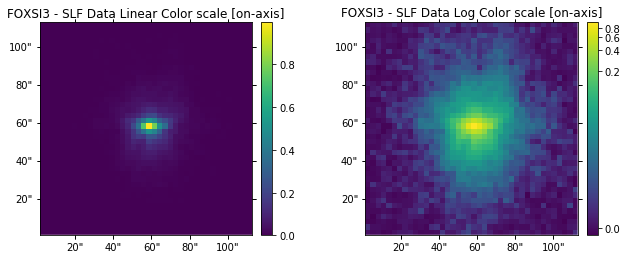

In [2]:
''' Plate scale '''
distance = 2. * u.m ## FOXSI focal distance
CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
binning = 2. ## binning used for collecting data.
plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

''' Path to the folder where to find your data and darks: '''
folder = '/Users/Kamilobu/Desktop/Developer/foxsi3_optics_cal/data/'

''' File names: '''
filename = 'kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'  ## name of your data fits file.
darkfilename = 'Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'  ## name of your darks fits file.
## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are 
## indicated over the names of the files.

## Read fits files using astropy.io.fits
fits = pyfits.open(folder+filename)
darkfits = pyfits.open(folder+darkfilename)
print('Data shape  : '+str(fits[0].data.shape))
print('Darks shape : '+str(darkfits[0].data.shape))

## Create data array corrected by darks:
data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)
max_pixel = np.unravel_index(np.argmax(data), data.shape)
fov = [20, 20] ## [px,px]
sdata = data[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]/data.max()

''' Create the WCS information '''
wcs_dict = {
    'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
    'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
    'CUNIT1':'arcsec',
    'CUNIT2':'arcsec',
    'CDELT1': plate_scale.value, ## Plate scale in arcsec
    'CDELT2': plate_scale.value, ## Plate scale in arcsec
    'CRPIX1':0,
    'CRPIX2':0,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'NAXIS1': sdata.shape[0],
    'NAXIS2': sdata.shape[1]
}
input_wcs = wcs.WCS(wcs_dict)

''' Create NDCube '''
datacube = NDCube(sdata, input_wcs)

# Create an ImageNormalize object
normLin = ImageNormalize(datacube.data, interval=MinMaxInterval(),
                      stretch=LinearStretch()) ## Linear Color Scale
normLog = ImageNormalize(datacube.data, interval=MinMaxInterval(),
                      stretch=LogStretch())    ## Log Color Scale

''' Plotting '''
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4),subplot_kw=dict(projection=datacube.wcs))
fig.subplots_adjust(wspace = 0.4)
## Linear Scale:
im1 = ax1.imshow(datacube.data, origin='lower', cmap=plt.cm.viridis, norm=normLin)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
#ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
#ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('FOXSI3 - SLF Data Linear Color scale [on-axis]',fontsize=12)
## Log Scale:
im2 = ax2.imshow(datacube.data, origin='lower', cmap=plt.cm.viridis, norm=normLog)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
#ax2.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
#ax2.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax2.set_title('FOXSI3 - SLF Data Log Color scale [on-axis]',fontsize=12)
plt.show()